In [3]:
# ============================================
# 📌 1. Install + Import Libraries
# ============================================
!pip install tensorflow pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (14,6)
plt.rcParams["font.size"] = 16
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["figure.dpi"] = 150

# Check GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# # ============================================
# # 📌 2. Load Dataset
# # ============================================
# df = pd.read_csv("/content/final_aqi_dataset.csv")
# df["datetime"] = pd.to_datetime(df["datetime"])
# df = df.set_index("datetime")
# df = df.sort_index()
# df = df.dropna()

# print(df.head())
# print(df.info())

# # ============================================
# # 📌 3. Feature Engineering
# # ============================================
# df["hour"] = df.index.hour
# df["month"] = df.index.month
# df["dayofweek"] = df.index.dayofweek

# # Cyclic encoding
# df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
# df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
# df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
# df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

# feature_cols = [
#     "pm2_5_ugm3", "pm10_ugm3", "co_ppm", "no2_ppb", "o3_ppm", "so2_ppb",
#     "temperature_2m", "relative_humidity_2m", "surface_pressure",
#     "precipitation", "cloudcover", "windspeed_10m",
#     "hour", "month", "hour_sin", "hour_cos", "month_sin", "month_cos"
# ]

# # ============================================
# # 📌 4. Train/Validation/Test Split
# # ============================================
# train_size = 0.8
# valid_size = 0.1
# n = len(df)
# train_end = int(n * train_size)
# valid_end = int(n * (train_size + valid_size))

# train = df.iloc[:train_end]
# valid = df.iloc[train_end:valid_end]
# test  = df.iloc[valid_end:]

# # Scaling features
# scaler_X = MinMaxScaler()
# scaler_y = MinMaxScaler()

# X_train = scaler_X.fit_transform(train[feature_cols])
# X_valid = scaler_X.transform(valid[feature_cols])
# X_test  = scaler_X.transform(test[feature_cols])

# y_train = scaler_y.fit_transform(train[["AQI"]])
# y_valid = scaler_y.transform(valid[["AQI"]])
# y_test  = scaler_y.transform(test[["AQI"]])

# # ============================================
# # 📌 5. Create LSTM/GRU Sequences
# # ============================================
# def create_sequences(X, y, seq_length=24):
#     X_seq, y_seq = [], []
#     for i in range(len(X) - seq_length):
#         X_seq.append(X[i:i+seq_length])
#         y_seq.append(y[i+seq_length])
#     return np.array(X_seq), np.array(y_seq)

# SEQ_LEN = 24  # past 24 hours to predict next hour
# X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN)
# X_valid_seq, y_valid_seq = create_sequences(X_valid, y_valid, SEQ_LEN)
# X_test_seq, y_test_seq   = create_sequences(X_test, y_test, SEQ_LEN)

# print("Train sequence shape:", X_train_seq.shape)

# # ============================================
# # 📌 6. Build LSTM/GRU Model
# # ============================================
# model = Sequential([
#     GRU(64, return_sequences=True, input_shape=(SEQ_LEN, len(feature_cols))),
#     Dropout(0.2),
#     GRU(32),
#     Dropout(0.2),
#     Dense(1)
# ])

# model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# model.summary()

# # Early stopping
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # ============================================
# # 📌 7. Train Model (GPU accelerated)
# # ============================================
# history = model.fit(
#     X_train_seq, y_train_seq,
#     validation_data=(X_valid_seq, y_valid_seq),
#     epochs=50,
#     batch_size=32,
#     callbacks=[early_stop],
#     verbose=1
# )

# # ============================================
# # 📌 8. Plot Training Progress
# # ============================================
# plt.figure(figsize=(12,5))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title("LSTM/GRU Training Progress")
# plt.xlabel("Epoch")
# plt.ylabel("MSE Loss")
# plt.legend()
# plt.grid(True)
# plt.show()

# # ============================================
# # 📌 9. Predictions + Evaluation
# # ============================================
# def inverse_scale(y_scaled):
#     return scaler_y.inverse_transform(y_scaled)

# y_valid_pred = model.predict(X_valid_seq)
# y_test_pred  = model.predict(X_test_seq)

# y_valid_true = inverse_scale(y_valid_seq)
# y_test_true  = inverse_scale(y_test_seq)
# y_valid_pred = inverse_scale(y_valid_pred)
# y_test_pred  = inverse_scale(y_test_pred)

# def evaluate(true, pred, label="Set"):
#     mae = mean_absolute_error(true, pred)
#     rmse = np.sqrt(mean_squared_error(true, pred))
#     r2 = r2_score(true, pred)
#     print(f"📌 {label} Evaluation")
#     print(f"MAE  = {mae:.4f}")
#     print(f"RMSE = {rmse:.4f}")
#     print(f"R²   = {r2:.4f}")
#     print("--------------------------------------")
#     return mae, rmse, r2

# evaluate(y_valid_true, y_valid_pred, "Validation")
# evaluate(y_test_true, y_test_pred, "Test")

# # ============================================
# # 📌 10. Publication-Quality Plots
# # ============================================

# # Actual vs Predicted
# plt.figure(figsize=(16,5))
# plt.plot(y_test_true, label="Actual AQI")
# plt.plot(y_test_pred, label="Predicted AQI", alpha=0.8)
# plt.title("Test Set: Actual vs Predicted AQI")
# plt.xlabel("Time Index")
# plt.ylabel("AQI")
# plt.legend()
# plt.grid(True)
# plt.show()

# # Training Loss Curve already plotted
# # Add other plots (hourly, daily, monthly, pollutant correlations, etc.)
# # Example: Daily Average AQI
# daily_avg = df['AQI'].resample('D').mean()
# plt.figure(figsize=(16,5))
# plt.plot(daily_avg.index, daily_avg, label="Daily Avg AQI", color='tab:orange')
# plt.title("Daily Average AQI")
# plt.xlabel("Date")
# plt.ylabel("AQI")
# plt.legend()
# plt.grid(True)
# plt.show()

# # ============================================
# # 📌 11. Example Inference Using New CSV
# # ============================================
# example = pd.read_csv("/content/example_input.csv")
# example["datetime"] = pd.to_datetime(example["datetime"])
# example = example.set_index("datetime")

# example["hour"] = example.index.hour
# example["month"] = example.index.month
# example["hour_sin"] = np.sin(2*np.pi*example["hour"]/24)
# example["hour_cos"] = np.cos(2*np.pi*example["hour"]/24)
# example["month_sin"] = np.sin(2*np.pi*example["month"]/12)
# example["month_cos"] = np.cos(2*np.pi*example["month"]/12)

# X_example = scaler_X.transform(example[feature_cols])
# # Convert to sequences
# X_example_seq = []
# for i in range(len(X_example)-SEQ_LEN):
#     X_example_seq.append(X_example[i:i+SEQ_LEN])
# X_example_seq = np.array(X_example_seq)

# example_preds = model.predict(X_example_seq)
# example["AQI_Predicted"] = np.nan
# example.iloc[SEQ_LEN:, example.columns.get_loc("AQI_Predicted")] = scaler_y.inverse_transform(example_preds).flatten()
# example.head()


Num GPUs Available:  1


In [4]:
# ============================================
# 📌 2. Load Dataset
# ============================================
df = pd.read_csv("/content/final_cleaned_interpolated.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")
df = df.sort_index()
df = df.dropna()

print(df.head())
print(df.info())

                     temperature_2m  relative_humidity_2m  surface_pressure  \
datetime                                                                      
2020-11-25 01:00:00            10.0                    88             872.4   
2020-11-25 02:00:00             9.6                    87             871.9   
2020-11-25 03:00:00             9.5                    86             871.5   
2020-11-25 04:00:00             9.2                    85             871.3   
2020-11-25 05:00:00             8.4                    89             870.9   

                     pressure_msl  precipitation  cloudcover  windspeed_10m  \
datetime                                                                      
2020-11-25 01:00:00        1018.3            0.0           3            2.5   
2020-11-25 02:00:00        1018.0            0.0           3            2.2   
2020-11-25 03:00:00        1017.6            0.0           0            2.5   
2020-11-25 04:00:00        1017.5            0.0   

In [5]:
# ============================================
# 📌 3. Feature Engineering
# ============================================
df["hour"] = df.index.hour
df["month"] = df.index.month
df["dayofweek"] = df.index.dayofweek

# Cyclic encoding
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

feature_cols = [
    "pm2_5_ugm3", "pm10_ugm3", "co_ppm", "no2_ppb", "o3_ppm", "so2_ppb",
    "temperature_2m", "relative_humidity_2m", "surface_pressure",
    "precipitation", "cloudcover", "windspeed_10m",
    "hour", "month", "hour_sin", "hour_cos", "month_sin", "month_cos"
]

In [6]:
# ============================================
# 📌 4. Train/Validation/Test Split
# ============================================
train_size = 0.8
valid_size = 0.1
n = len(df)
train_end = int(n * train_size)
valid_end = int(n * (train_size + valid_size))

train = df.iloc[:train_end]
valid = df.iloc[train_end:valid_end]
test  = df.iloc[valid_end:]

# Scaling features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(train[feature_cols])
X_valid = scaler_X.transform(valid[feature_cols])
X_test  = scaler_X.transform(test[feature_cols])

y_train = scaler_y.fit_transform(train[["AQI"]])
y_valid = scaler_y.transform(valid[["AQI"]])
y_test  = scaler_y.transform(test[["AQI"]])

In [7]:
# ============================================
# 📌 5. Create LSTM/GRU Sequences
# ============================================
def create_sequences(X, y, seq_length=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LEN = 24  # past 24 hours to predict next hour
X_train_seq, y_train_seq = create_sequences(X_train, y_train, SEQ_LEN)
X_valid_seq, y_valid_seq = create_sequences(X_valid, y_valid, SEQ_LEN)
X_test_seq, y_test_seq   = create_sequences(X_test, y_test, SEQ_LEN)

print("Train sequence shape:", X_train_seq.shape)

Train sequence shape: (34425, 24, 18)


In [8]:
# ============================================
# 📌 6. Build LSTM/GRU Model
# ============================================
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(SEQ_LEN, len(feature_cols))),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 64)         │        16,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,569 (99.88 KB)

 Trainable params: 25,569 (99.88 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# ============================================
# 📌 7. Train Model (GPU accelerated)
# ============================================
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_valid_seq, y_valid_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0295 - mae: 0.1078 - val_loss: 0.0058 - val_mae: 0.0559
Epoch 2/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0077 - mae: 0.0587 - val_loss: 0.0059 - val_mae: 0.0575
Epoch 3/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0068 - mae: 0.0541 - val_loss: 0.0054 - val_mae: 0.0541
Epoch 4/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0061 - mae: 0.0495 - val_loss: 0.0045 - val_mae: 0.0477
Epoch 5/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0055 - mae: 0.0464 - val_loss: 0.0033 - val_mae: 0.0410
Epoch 6/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0043 - mae: 0.0413 - val_loss: 0.0026 - val_mae: 0.0360
Epoch 7/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0038 - mae: 0.0388 - val_loss: 0.0029 - val_mae: 0.0376
Epoch 8/50
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0036 - mae: 0.0363 - val_loss: 0.0020 - val_mae: 0.0300
Epoch 9/50
1076/1076 ━━━━━━━━━━━━━━━━

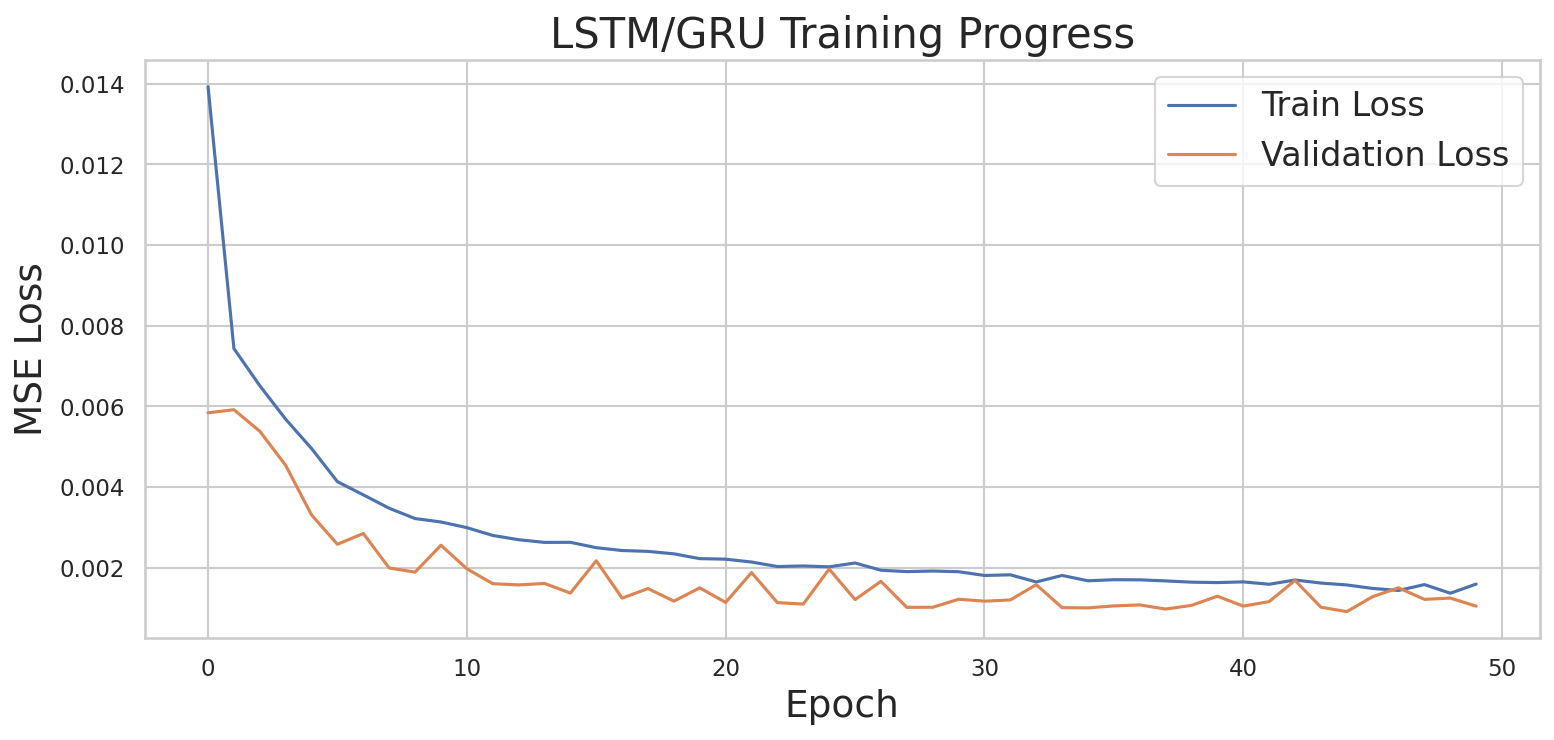

In [10]:
# ============================================
# 📌 8. Plot Training Progress
# ============================================
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("LSTM/GRU Training Progress")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# ============================================
# 📌 9. Predictions + Evaluation
# ============================================
def inverse_scale(y_scaled):
    return scaler_y.inverse_transform(y_scaled)

y_valid_pred = model.predict(X_valid_seq)
y_test_pred  = model.predict(X_test_seq)

y_valid_true = inverse_scale(y_valid_seq)
y_test_true  = inverse_scale(y_test_seq)
y_valid_pred = inverse_scale(y_valid_pred)
y_test_pred  = inverse_scale(y_test_pred)

def evaluate(true, pred, label="Set"):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2 = r2_score(true, pred)
    print(f"📌 {label} Evaluation")
    print(f"MAE  = {mae:.4f}")
    print(f"RMSE = {rmse:.4f}")
    print(f"R²   = {r2:.4f}")
    print("--------------------------------------")
    return mae, rmse, r2

evaluate(y_valid_true, y_valid_pred, "Validation")
evaluate(y_test_true, y_test_pred, "Test")

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
📌 Validation Evaluation
MAE  = 9.0525
RMSE = 14.7338
R²   = 0.9543
--------------------------------------
📌 Test Evaluation
MAE  = 7.4107
RMSE = 11.1473
R²   = 0.9487
--------------------------------------


(7.410687727095069, np.float64(11.147253633428631), 0.9487159810803375)

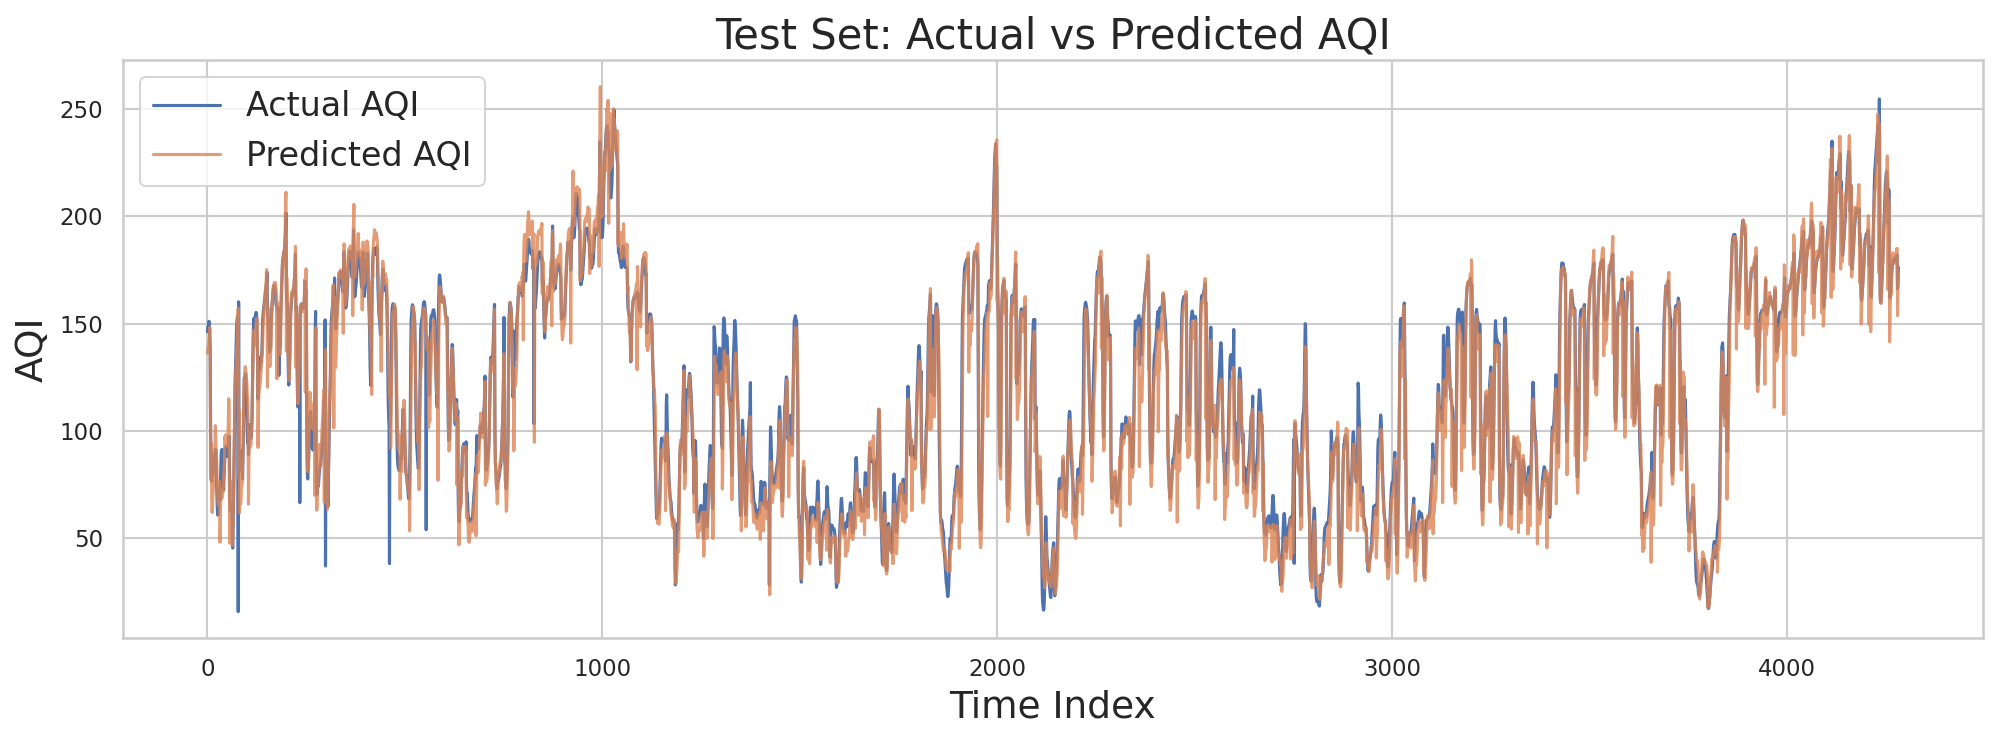

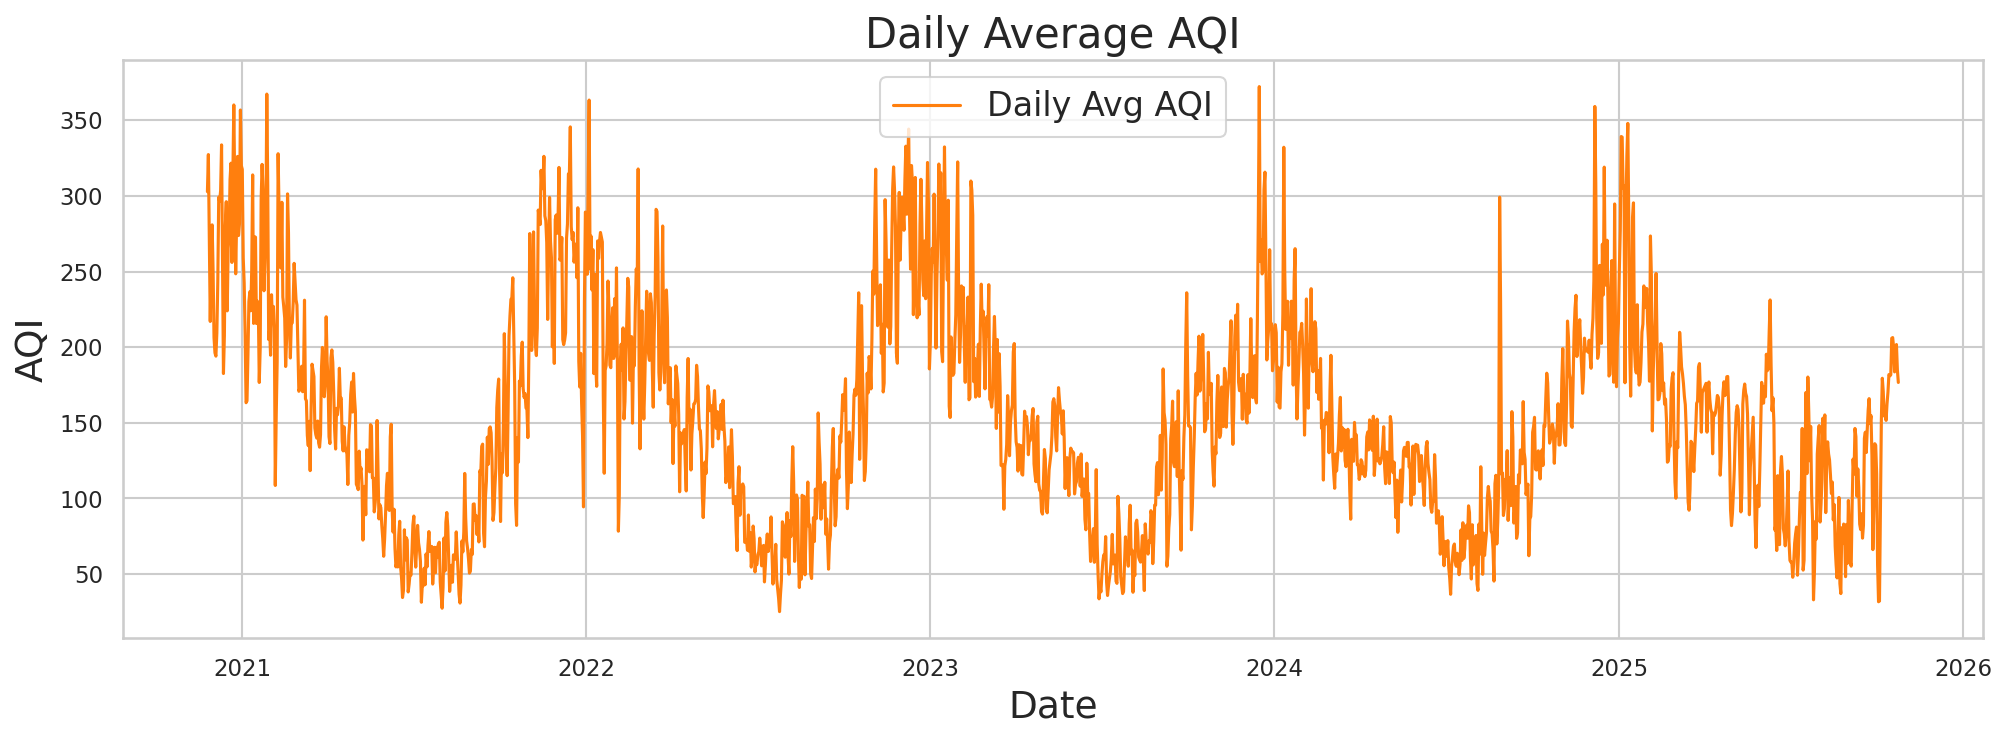

In [12]:
# ============================================
# 📌 10. Publication-Quality Plots
# ============================================

# Actual vs Predicted
plt.figure(figsize=(16,5))
plt.plot(y_test_true, label="Actual AQI")
plt.plot(y_test_pred, label="Predicted AQI", alpha=0.8)
plt.title("Test Set: Actual vs Predicted AQI")
plt.xlabel("Time Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

# Training Loss Curve already plotted
# Add other plots (hourly, daily, monthly, pollutant correlations, etc.)
# Example: Daily Average AQI
daily_avg = df['AQI'].resample('D').mean()
plt.figure(figsize=(16,5))
plt.plot(daily_avg.index, daily_avg, label="Daily Avg AQI", color='tab:orange')
plt.title("Daily Average AQI")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# ============================================
# 📌 11. Example Inference Using New CSV
# ============================================
example = pd.read_csv("/content/example_input.csv")
example["datetime"] = pd.to_datetime(example["datetime"])
example = example.set_index("datetime")

example["hour"] = example.index.hour
example["month"] = example.index.month
example["hour_sin"] = np.sin(2*np.pi*example["hour"]/24)
example["hour_cos"] = np.cos(2*np.pi*example["hour"]/24)
example["month_sin"] = np.sin(2*np.pi*example["month"]/12)
example["month_cos"] = np.cos(2*np.pi*example["month"]/12)

X_example = scaler_X.transform(example[feature_cols])
# Convert to sequences
X_example_seq = []
for i in range(len(X_example)-SEQ_LEN):
    X_example_seq.append(X_example[i:i+SEQ_LEN])
X_example_seq = np.array(X_example_seq)

example_preds = model.predict(X_example_seq)
example["AQI_Predicted"] = np.nan
example.iloc[SEQ_LEN:, example.columns.get_loc("AQI_Predicted")] = scaler_y.inverse_transform(example_preds).flatten()
example.head()

1345/1345 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


,temperature_2m,relative_humidity_2m,surface_pressure,pressure_msl,precipitation,cloudcover,windspeed_10m,direct_radiation,co_ppm,no2_ppb,...,pm2_5_ugm3,pm10_ugm3,AQI,hour,month,hour_sin,hour_cos,month_sin,month_cos,AQI_Predicted
datetime,,,,,,,,,,,,,,,,,,,,,
2020-11-25 01:00:00,10.0,88,872.4,1018.3,0.0,3,2.5,0.0,2.576596,27.345745,...,243.48,314.88,293.142342,1,11,0.258819,0.965926,-0.5,0.866025,NaN
2020-11-25 02:00:00,9.6,87,871.9,1018.0,0.0,3,2.2,0.0,2.904526,26.250000,...,257.94,346.24,308.372973,2,11,0.500000,0.866025,-0.5,0.866025,NaN
2020-11-25 03:00:00,9.5,86,871.5,1017.6,0.0,0,2.5,0.0,3.326149,28.074468,...,289.31,393.51,339.460360,3,11,0.707107,0.707107,-0.5,0.866025,NaN
2020-11-25 04:00:00,9.2,85,871.3,1017.5,0.0,0,2.9,0.0,0.983789,11.031915,...,95.82,120.04,171.818546,4,11,0.866025,0.500000,-0.5,0.866025,NaN
2020-11-25 05:00:00,8.4,89,870.9,1017.5,0.0,14,5.2,0.0,0.878386,9.117021,...,101.84,122.11,174.926870,5,11,0.965926,0.258819,-0.5,0.866025,NaN
